# Text Classification with Naive Bayes, Logistic Regression, SVM

This notebook demonstrates text classification using three different algorithms:

- **Mulitnominal Naive Bayes**
- **Logistic Regression**
- **Support Vector Machines (SVM)**

### The Dataset
- **Economic news articles** from Figure-Eight
- **~8000 articles** tagged as relevant/not relevant to US Economy
- **Binary classification problem:** relevant (1) vs non-relevant (0) 

In [1]:
# Install required packages
!pip install numpy pandas scikit-learn matplotlib

  Using cached numpy-2.3.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached numpy-2.3.2-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 11.3 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 11.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 11.1 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.0 MB/s  0:00:00 eta 0:00:01
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ━━━━━━

In [33]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib.pyplot as plt

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/Users/satkarkarki/.venv/lib/python3.11/site-packages/sklearn/metrics/__init__.py)

## 1. Load and explore the dataset

In [5]:
import os

# Check if the file exists
file_path = "/Users/satkarkarki/Desktop/usd/Learning/practical-nlp/my-lab/text-classification/simple-ml-algorithms/Full-Economic-News-DFE-839861.csv"
print("File exists:", os.path.exists(file_path))

# List files in the Data directory to see what's available
data_dir = "/Users/satkarkarki/Desktop/usd/Learning/practical-nlp/my-lab/text-classification/simple-ml-algorithms"
print("\nFiles in Data directory:")
if os.path.exists(data_dir):
    print(os.listdir(data_dir))
else:
    print("Data directory not found")

File exists: True

Files in Data directory:
['Full-Economic-News-DFE-839861.csv', '.DS_Store', 'TextClassification-checkpoint.ipynb', 'README.md', '.ipynb_checkpoints', 'data']


In [7]:
# Load the dataset using the full absolute path
our_data = pd.read_csv("/Users/satkarkarki/Desktop/usd/Learning/practical-nlp/my-lab/text-classification/simple-ml-algorithms/Full-Economic-News-DFE-839861.csv", encoding="ISO-8859-1")

# Check if it loaded successfully
print("Data loaded successfully!")
print("Dataset shape:", our_data.shape)

Data loaded successfully!
Dataset shape: (8000, 15)


In [8]:
# Look at the first few rows
print("\nFirst few rows:")
print(our_data.head())


First few rows:
    _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  842613455    False   finalized                   3     12/5/15 17:48   
1  842613456    False   finalized                   3     12/5/15 16:54   
2  842613457    False   finalized                   3      12/5/15 1:59   
3  842613458    False   finalized                   3      12/5/15 2:19   
4  842613459    False   finalized                   3     12/5/15 17:48   

   positivity  positivity:confidence relevance  relevance:confidence  \
0         3.0                 0.6400       yes                 0.640   
1         NaN                    NaN        no                 1.000   
2         NaN                    NaN        no                 1.000   
3         NaN                 0.0000        no                 0.675   
4         3.0                 0.3257       yes                 0.640   

       articleid      date                                           headline  \
0  wsj_398217788  

In [9]:
# Check column names
print("\nColumn names:")
print(our_data.columns.tolist())



Column names:
['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'positivity', 'positivity:confidence', 'relevance', 'relevance:confidence', 'articleid', 'date', 'headline', 'positivity_gold', 'relevance_gold', 'text']


In [10]:
# Check the relevance column values
print("\nUnique values in 'relevance' column:")
print(our_data["relevance"].value_counts())


Unique values in 'relevance' column:
relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64


There seems to be a sever imbalance between articles categorized as **relevant to US** while there are also seems to be three categories. We need to clean the dataset by dropping any rows that are labeled as 'not sure' as it is a binary classification task.

In [11]:
# Dropping 'not sure' and converting 'yes/no' labels into a numerical value
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.
our_data.shape

(7991, 2)

## 2. Text Pre-processing

The pre-processing steps involve removing the HTML `<br>` tags, punctuations, numbers, and stopwords. We are using sklearn's list of stopwords.

This matters for ML tasks as it reduces noise, and the algorithm focuses on important words.

In [12]:
# Method 2: Use CountVectorizer with stop_words='english'
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer with English stop words
vect = CountVectorizer(stop_words='english')
stopwords = vect.get_stop_words()

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

# Test the function
test_text = "This is a test document with some <br/> tags and punctuation!"
print("Original:", test_text)
print("Cleaned:", clean(test_text))

Original: This is a test document with some <br/> tags and punctuation!
Cleaned: This test document br tags punctuation


## 3. Modeling

Now that the dataset is ready, it will be split into training (75%) and test (25%) sets. 

In [13]:
# Step 1: train-test split
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the data
X = our_data.text  # Features (the text)
y = our_data.relevance  # Target (0 or 1)

# Split into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (5993,)
Testing set size: (1998,)


In [22]:
# Step 2: Feature Extraction (text to numbers)
# Create a vectorizer with your cleaning function
vect = CountVectorizer(preprocessor=clean, max_features=5000)

# Fit on training data and transform both training and test data
X_train_dtm = vect.fit_transform(X_train)  # Learn vocabulary from training data
X_test_dtm = vect.transform(X_test)        # Use same vocabulary for test data

print("Training features shape:", X_train_dtm.shape)
print("Testing features shape:", X_test_dtm.shape)

Training features shape: (5993, 5000)
Testing features shape: (1998, 5000)


### Naive Bayes Classifier

The first model to be trained on will be the Naive Bayes.

In [25]:
# Step 3: Train the model

# Create and train the model
nb = MultinomialNB()  # Create Naive Bayes classifier
nb.fit(X_train_dtm, y_train)  # Train the model

# Make predictions
y_pred_class = nb.predict(X_test_dtm)  # Predict classes (0 or 1)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]  # Predict probabilities

print("Model trained successfully!")

Model trained successfully!


In [29]:
# Step 4: Evaluate the Model

#Calculate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_class))

# Calculate AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Create confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(cnf_matrix)

Accuracy: 0.6876876876876877
AUC: 0.7282608695652173
Confusion Matrix:
[[1152  504]
 [ 120  222]]


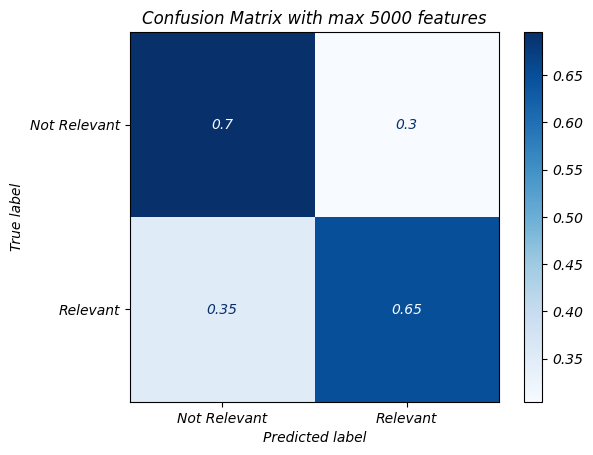

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# assuming you have cnf_matrix and your model, X_test, y_test
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_class,
    display_labels=['Not Relevant', 'Relevant'],
    cmap=plt.cm.Blues,
    normalize='true'
)
plt.title('Confusion Matrix with max 5000 features')
plt.show()


### Logistic Regression

=== Logistic Regression Results ===
Accuracy: 0.7362362362362362
AUC: 0.6585939486397152


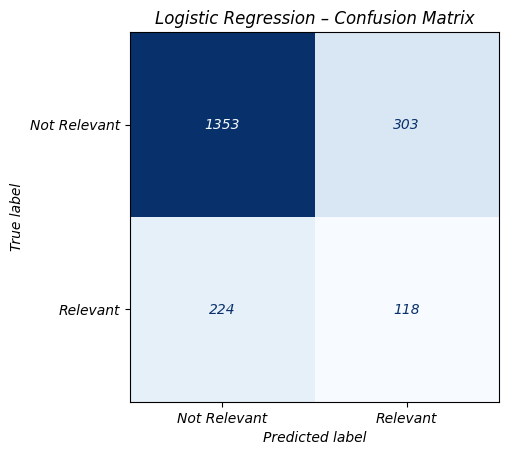

In [36]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Create and train Logistic Regression with balanced class weights
logreg = LogisticRegression(class_weight="balanced", random_state=1)
logreg.fit(X_train_dtm, y_train)

# Make predictions
y_pred_class_lr = logreg.predict(X_test_dtm)
y_pred_prob_lr = logreg.predict_proba(X_test_dtm)[:, 1]

# Evaluate the model
print("=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_class_lr))
print("AUC:", roc_auc_score(y_test, y_pred_prob_lr))

# Confusion Matrix
cnf_matrix_lr = confusion_matrix(y_test, y_pred_class_lr)

# Plot Confusion Matrix (Normalized)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_lr, display_labels=['Not Relevant', 'Relevant'])
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.title('Logistic Regression – Confusion Matrix')
plt.show()


### Support Vector Machine

- Since SVM takes time train, the feature size will be kept 1,000 instead of 5,000.

In [ ]:
# Import SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Step 1: Create new vectorizer with 1000 features
vect_1000 = CountVectorizer(preprocessor=clean, max_features=1000)

# Step 2: Transform data with reduced features
X_train_dtm_1000 = vect_1000.fit_transform(X_train)
X_test_dtm_1000  = vect_1000.transform(X_test)

print("=== Feature Reduction ===")
print("Original features:", X_train_dtm.shape[1])
print("Reduced features: ", X_train_dtm_1000.shape[1])
print("Training shape:", X_train_dtm_1000.shape)
print("Testing shape: ", X_test_dtm_1000.shape)

# Step 3: Train SVM with balanced class weights
svm = LinearSVC(class_weight="balanced", random_state=1)
svm.fit(X_train_dtm_1000, y_train)

# Step 4: Predictions and scores
y_pred_class_svm = svm.predict(X_test_dtm_1000)
# decision_function gives continuous scores suitable for AUC/ROC
y_scores_svm = svm.decision_function(X_test_dtm_1000)

# Step 5: Evaluate
print("\n=== SVM Results (1000 features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_class_svm))
print("AUC:", roc_auc_score(y_test, y_scores_svm))

# Step 6: Confusion matrix plot (sklearn 1.3+)
cm_svm = confusion_matrix(y_test, y_pred_class_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                              display_labels=['Not Relevant','Relevant'])
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.title('SVM – Confusion Matrix (1000 features)')
plt.show()


### Complete Model Comparision

In [36]:
# Compare all three models
print("=== Complete Model Comparison ===")
print("Naive Bayes (5000 features):")
print("  Accuracy:", accuracy_score(y_test, y_pred_class))
print("  AUC:", roc_auc_score(y_test, y_pred_prob))

print("\nLogistic Regression (5000 features):")
print("  Accuracy:", accuracy_score(y_test, y_pred_class_lr))
print("  AUC:", roc_auc_score(y_test, y_pred_prob_lr))

print("\nSVM (1000 features):")
print("  Accuracy:", accuracy_score(y_test, y_pred_class_svm))
print("  AUC: Not available (LinearSVC doesn't provide probabilities)")

=== Complete Model Comparison ===
Naive Bayes (5000 features):
  Accuracy: 0.6876876876876877
  AUC: 0.7282608695652173

Logistic Regression (5000 features):
  Accuracy: 0.7362362362362362
  AUC: 0.6585939486397152

SVM (1000 features):
  Accuracy: 0.6836836836836837
  AUC: Not available (LinearSVC doesn't provide probabilities)


- Logistic Regression wins for overall accuracy
- Naive Bayes wins for class separation (highest AUC)
- SVM is efficient: good performance with fewer features
- Class imbalance affects all models (82% vs 18%)